# Shapley Values of DNN

In [21]:
import shap
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle
from sklearn.model_selection import train_test_split

In [22]:
from DNN_Architectures import *

In [23]:
# Get data
data_path = os.path.join('..', 'temporal_models_training', 'NBA_temporal_dataset.pkl')

with open(data_path, 'rb') as file:
    data = pickle.load(file)

X_primary = data['X_primary']
X_opposing = data['X_opposing']
y = data['y']

X_primary = torch.tensor(X_primary, dtype=torch.float32)
X_opposing = torch.tensor(X_opposing, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [24]:
# Initialize models
dual_ffn = DualTeamFFN()
single_ffn = FFN()
dual_lstm = SiameseDualLSTM()
single_lstm = NBA_LSTM()

# Load saved models
path_to_models = os.path.join('..', 'models')

dual_ffn.load_state_dict(torch.load(os.path.join(path_to_models, 'dual_ffn_model.pth')))
single_ffn.load_state_dict(torch.load(os.path.join(path_to_models, 'single_ffn_model.pth')))
dual_lstm.load_state_dict(torch.load(os.path.join(path_to_models, 'dual_lstm_model.pth')))
single_lstm.load_state_dict(torch.load(os.path.join(path_to_models, 'single_lstm_model.pth')))


C:\Users\Alex1\AppData\Local\Temp\ipykernel_44368\3703314518.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dual_ffn.load_state_dict(torch.load(os.path.join(path_to_mo

<All keys matched successfully>

## 1) Below are for FFN with flattened time series data

In [44]:
# For single FFN
X_primary_flatten = X_primary.reshape(X_primary.shape[0], -1)
X_opposing_flatten = X_opposing.reshape(X_opposing.shape[0], -1)
X_ffn = torch.cat((X_primary_flatten, X_opposing_flatten), dim=1)

# Get background and to_explain
background, to_explain = train_test_split(X_ffn, test_size=0.1, random_state=42)

# Limit the size of the background set (e.g., 100 samples)
background = background[:5000]  # First 100 samples from the background set

# Limit the size of the to_explain set (e.g., 10 samples)
to_explain = to_explain[:100]  # First 10 samples from the remaining data

base_feature_list = ['team_id_primary',
 'fgm_primary',
 'fga_primary',
 'fg_pct_primary',
 'fg3m_primary',
 'fg3a_primary',
 'fg3_pct_primary',
 'ftm_primary',
 'fta_primary',
 'ft_pct_primary',
 'oreb_primary',
 'dreb_primary',
 'reb_primary',
 'ast_primary',
 'stl_primary',
 'blk_primary',
 'tov_primary',
 'pf_primary',
 'pts_primary',
 'rest_days_primary',
 'team_id_opposing',
 'fgm_opposing',
 'fga_opposing',
 'fg_pct_opposing',
 'fg3m_opposing',
 'fg3a_opposing',
 'fg3_pct_opposing',
 'ftm_opposing',
 'fta_opposing',
 'ft_pct_opposing',
 'oreb_opposing',
 'dreb_opposing',
 'reb_opposing',
 'ast_opposing',
 'stl_opposing',
 'blk_opposing',
 'tov_opposing',
 'pf_opposing',
 'pts_opposing',
 'rest_days_opposing',
 'season_type',
 'subject_is_home'] 

feature_names = [
    f"{team}_t{5 - t}_{feat}"
    for team in ['primary', 'opposing']
    for t in range(5)
    for feat in base_feature_list
]

### 1a) FFN that combines both team's previous game data into input

In [45]:
single_ffn.eval()
explainer = shap.DeepExplainer(single_ffn, background)
shap_values = explainer.shap_values(to_explain)

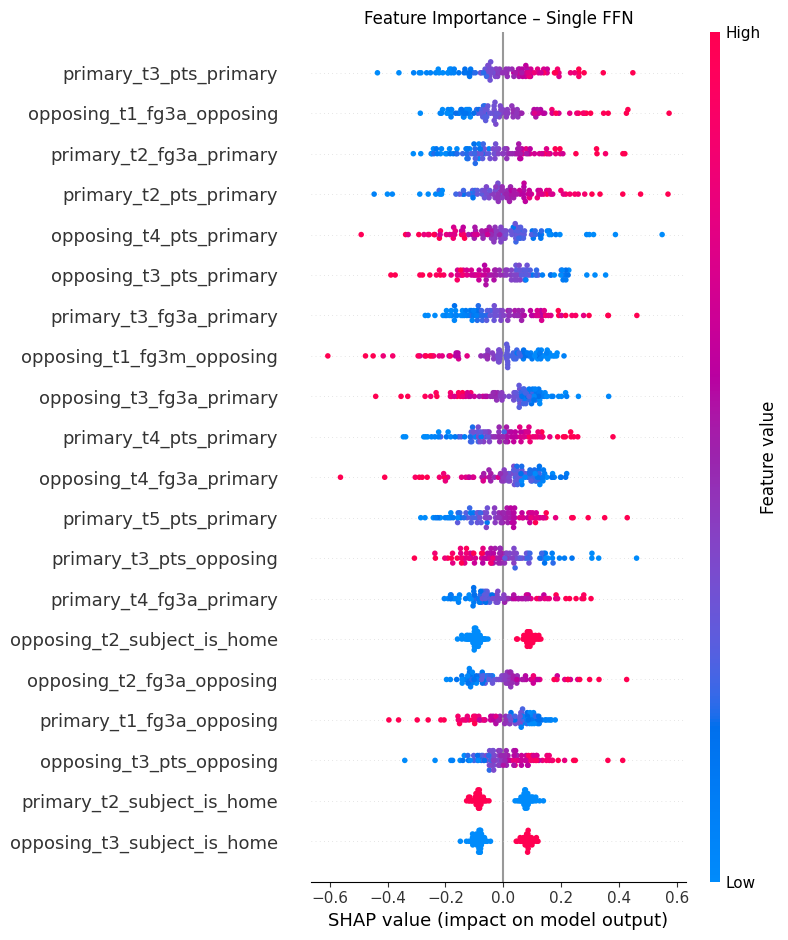

In [46]:
shap.summary_plot(shap_values.squeeze(-1), to_explain.numpy(), feature_names=feature_names, show=False)
# Add a custom title for the FFN
plt.title("Feature Importance – Single FFN")
plt.tight_layout()
plt.show()

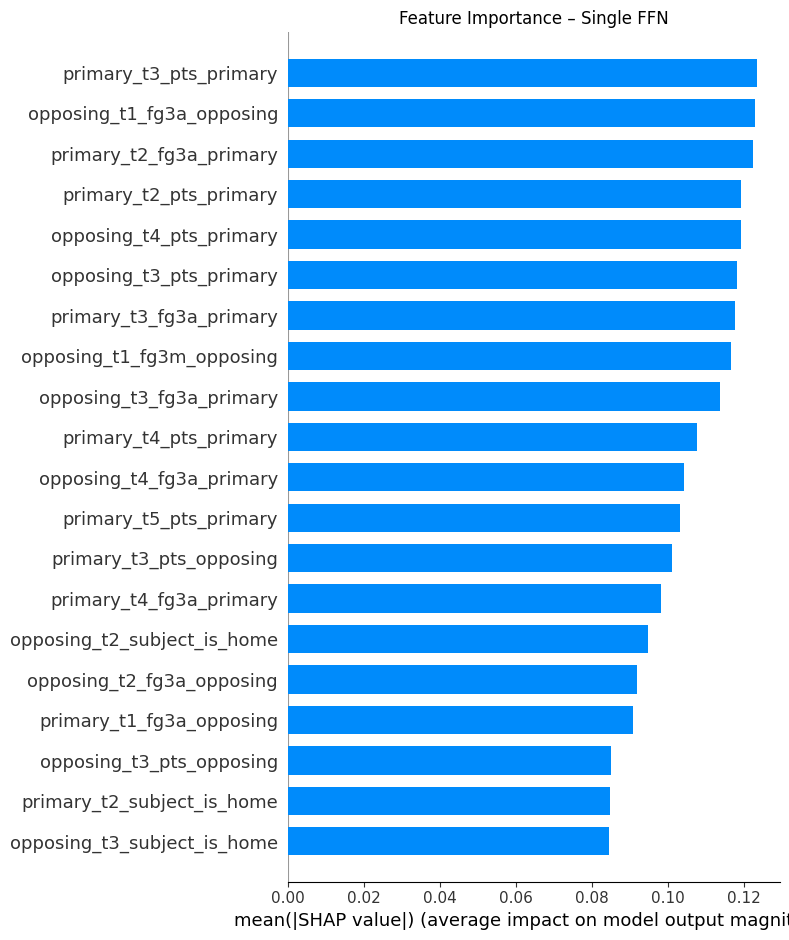

In [47]:
shap.summary_plot(shap_values.squeeze(-1), to_explain, plot_type="bar", feature_names=feature_names, show = False)

# Add a custom title for the FFN
plt.title("Feature Importance – Single FFN")
plt.tight_layout()
plt.show()

In [48]:
# Compute mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0).squeeze(-1)

# Get indices of features sorted by importance (descending)
sorted_indices = np.argsort(-mean_abs_shap)

# Print ranked features with their importance
print("Feature Importance – Single FFN")
print("_______________________________")
for i in sorted_indices:
    print(f"{feature_names[i]}: {mean_abs_shap[i]:.5f}")


Feature Importance – Single FFN
_______________________________
primary_t3_pts_primary: 0.12338
opposing_t1_fg3a_opposing: 0.12301
primary_t2_fg3a_primary: 0.12245
primary_t2_pts_primary: 0.11928
opposing_t4_pts_primary: 0.11927
opposing_t3_pts_primary: 0.11829
primary_t3_fg3a_primary: 0.11771
opposing_t1_fg3m_opposing: 0.11675
opposing_t3_fg3a_primary: 0.11383
primary_t4_pts_primary: 0.10763
opposing_t4_fg3a_primary: 0.10440
primary_t5_pts_primary: 0.10315
primary_t3_pts_opposing: 0.10106
primary_t4_fg3a_primary: 0.09819
opposing_t2_subject_is_home: 0.09486
opposing_t2_fg3a_opposing: 0.09183
primary_t1_fg3a_opposing: 0.09083
opposing_t3_pts_opposing: 0.08518
primary_t2_subject_is_home: 0.08469
opposing_t3_subject_is_home: 0.08448
primary_t5_subject_is_home: 0.08420
primary_t1_fg3m_opposing: 0.08206
opposing_t2_fg3a_primary: 0.07956
opposing_t2_fta_opposing: 0.07928
primary_t2_fg3a_opposing: 0.07421
primary_t1_fga_primary: 0.07337
primary_t5_pts_opposing: 0.07254
opposing_t2_fg3m_oppos

### 1b) FFN that separates both team's previous game data and combines later

In [49]:
dual_ffn.eval()
explainer = shap.DeepExplainer(dual_ffn, background)
shap_values = explainer.shap_values(to_explain)

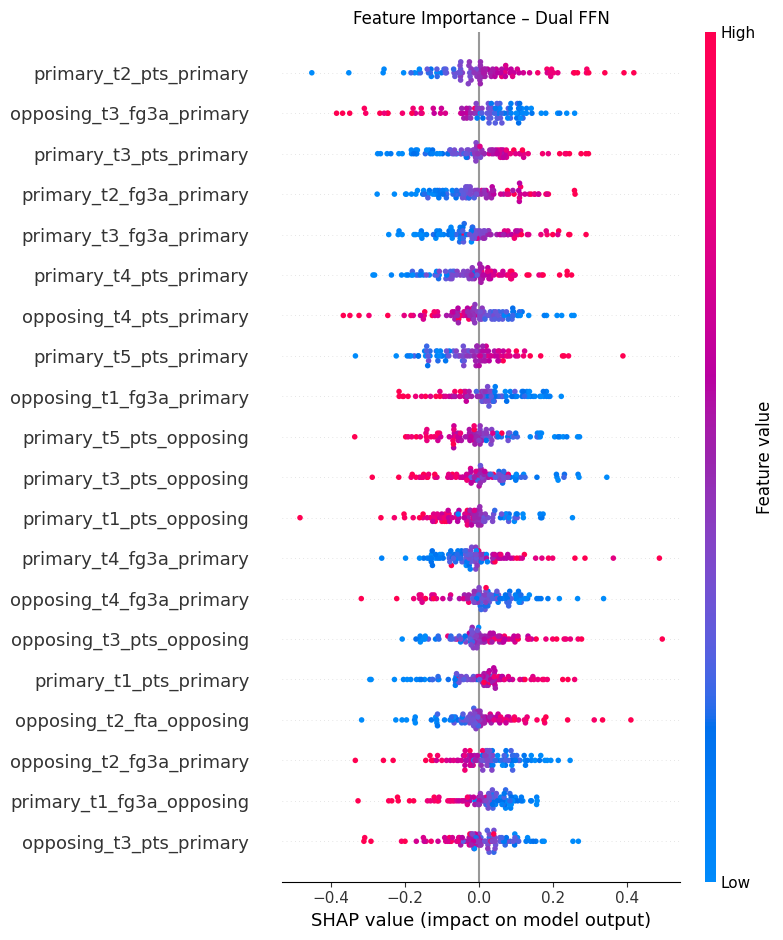

In [50]:
shap.summary_plot(shap_values.squeeze(-1), to_explain.numpy(), feature_names=feature_names, show=False)
plt.title("Feature Importance – Dual FFN")
plt.tight_layout()
plt.show()

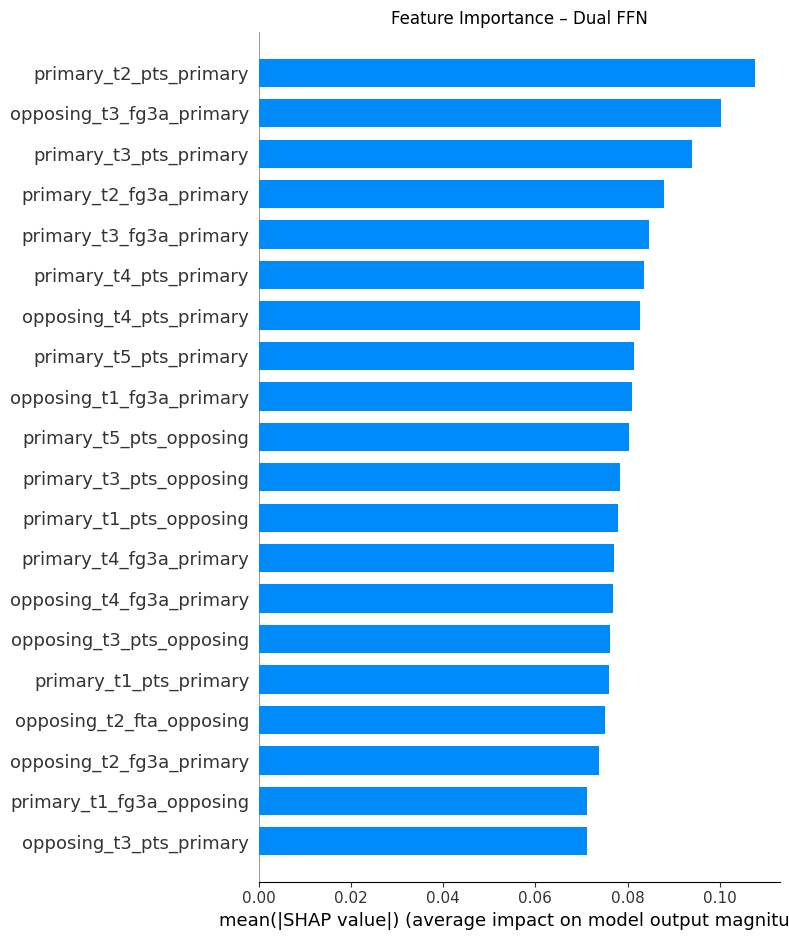

In [51]:
shap.summary_plot(shap_values.squeeze(-1), to_explain, plot_type="bar", feature_names=feature_names, show=False)
plt.title("Feature Importance – Dual FFN")
plt.tight_layout()
plt.show()

In [52]:
# Compute mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_values).mean(axis=0).squeeze(-1)

# Get indices of features sorted by importance (descending)
sorted_indices = np.argsort(-mean_abs_shap)

# Print ranked features with their importance
print("Feature Importance – Dual FFN")
for i in sorted_indices:
    print(f"{feature_names[i]}: {mean_abs_shap[i]:.5f}")

Feature Importance – Dual FFN
primary_t2_pts_primary: 0.10771
opposing_t3_fg3a_primary: 0.10018
primary_t3_pts_primary: 0.09395
primary_t2_fg3a_primary: 0.08787
primary_t3_fg3a_primary: 0.08476
primary_t4_pts_primary: 0.08366
opposing_t4_pts_primary: 0.08261
primary_t5_pts_primary: 0.08144
opposing_t1_fg3a_primary: 0.08097
primary_t5_pts_opposing: 0.08026
primary_t3_pts_opposing: 0.07842
primary_t1_pts_opposing: 0.07797
primary_t4_fg3a_primary: 0.07707
opposing_t4_fg3a_primary: 0.07693
opposing_t3_pts_opposing: 0.07618
primary_t1_pts_primary: 0.07588
opposing_t2_fta_opposing: 0.07509
opposing_t2_fg3a_primary: 0.07391
primary_t1_fg3a_opposing: 0.07119
opposing_t3_pts_primary: 0.07111
opposing_t2_pts_primary: 0.07055
primary_t1_fta_opposing: 0.06989
primary_t2_pts_opposing: 0.06962
primary_t1_fg3a_primary: 0.06578
opposing_t2_pts_opposing: 0.06474
opposing_t2_fg3a_opposing: 0.06463
primary_t2_subject_is_home: 0.06388
opposing_t1_fgm_opposing: 0.06218
opposing_t1_fg3m_opposing: 0.06212
op

## 2) LSTMs

In [ ]:
# For single lstm 
X_lstm = torch.cat((X_primary, X_opposing), dim=-1)

print(X_lstm.shape)

# Get background and to_explain
background, to_explain = train_test_split(X_ffn, test_size=0.1, random_state=42)

# Limit the size of the background set (e.g., 100 samples)
background = background[:5000]  # First 100 samples from the background set

# Limit the size of the to_explain set (e.g., 10 samples)
to_explain = to_explain[:100]  # First 10 samples from the remaining data

base_feature_list = ['team_id_primary',
 'fgm_primary',
 'fga_primary',
 'fg_pct_primary',
 'fg3m_primary',
 'fg3a_primary',
 'fg3_pct_primary',
 'ftm_primary',
 'fta_primary',
 'ft_pct_primary',
 'oreb_primary',
 'dreb_primary',
 'reb_primary',
 'ast_primary',
 'stl_primary',
 'blk_primary',
 'tov_primary',
 'pf_primary',
 'pts_primary',
 'rest_days_primary',
 'team_id_opposing',
 'fgm_opposing',
 'fga_opposing',
 'fg_pct_opposing',
 'fg3m_opposing',
 'fg3a_opposing',
 'fg3_pct_opposing',
 'ftm_opposing',
 'fta_opposing',
 'ft_pct_opposing',
 'oreb_opposing',
 'dreb_opposing',
 'reb_opposing',
 'ast_opposing',
 'stl_opposing',
 'blk_opposing',
 'tov_opposing',
 'pf_opposing',
 'pts_opposing',
 'rest_days_opposing',
 'season_type',
 'subject_is_home'] 

feature_names = [
    f"{team}_t{5 - t}_{feat}"
    for team in ['primary', 'opposing']
    for t in range(5)
    for feat in base_feature_list

torch.Size([83178, 5, 84])
